<a href="https://colab.research.google.com/github/jianna4/skindisease-detector/blob/main/skindisease2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
syedalinaqvi_augmented_skin_conditions_image_dataset_path = kagglehub.dataset_download('syedalinaqvi/augmented-skin-conditions-image-dataset')

print('Data source import complete.')


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras import Input, regularizers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Conv2D, MaxPooling2D, Flatten, Dropout ,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import json
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness
from tensorflow.keras import Sequential


2025-11-23 16:09:48.871136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763914189.062165      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763914189.115571      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
# Set your dataset directory
dataset_dir = '/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions'#insert yours

# Load the dataset
dataset = image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)


Found 2394 files belonging to 6 classes.


I0000 00:00:1763914205.207147      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
# Split dataset
train_size = 0.8
total_batches = tf.data.experimental.cardinality(dataset).numpy()
train_batches = int(train_size * total_batches)
train_dataset = dataset.take(train_batches)
test_dataset = dataset.skip(train_batches)
val_size = 0.1
val_batches = int(val_size * total_batches)
validation_dataset = test_dataset.take(val_batches)
test_dataset = test_dataset.skip(val_batches)


In [ ]:
#data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomBrightness(0.1)
])


In [ ]:
#applying the augmentation only on training dataset
def augment(images, labels):
    images = data_augmentation(images, training=True)
    return images, labels

train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# Prefetch for speed
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


In [ ]:
# Load pre-trained ResNet50 without the top classifier layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base initially
base_model.trainable = False

# Build custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)       # Converts features to 1D vector no need for flatten
x = Dense(1024, activation='relu')(x) # Fully connected layer
x = Dropout(0.5)(x)                   # Prevent overfitting
predictions = Dense(6, activation='softmax')(x)  # 6 classes

# Final model
model = Model(inputs=base_model.input, outputs=predictions)
#the FUNCTIONAL API (Model ) allows complex architecture withmultiple inputand output

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


the suquential model was:
model = tf.keras.models.Sequential([
     # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.0001),
           input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu',
           kernel_regularizer=regularizers.l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(128, activation='relu'),
    #Dropout(0.4),                 # VERY IMPORTANT
    Dense(6, activation='softmax')
])

In [ ]:


# --- CALLBACKS ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # reduce LR by 50%
    patience=2,        # if val_loss doesn't improve for 2 epochs
    min_lr=1e-10,
    verbose=1
)

# Compile the model
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,       # 👈 PUT EPOCHS HERE
    batch_size=32,
    callbacks=[early_stop, reduce_lr]    # 👈 ADD CALLBACKS HERE
)

Epoch 1/10


I0000 00:00:1763914216.487647     116 service.cc:148] XLA service 0x7d29bc0027d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763914216.488398     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763914218.316550     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/60 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.1797 - loss: 2.7611 

I0000 00:00:1763914222.246254     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 283ms/step - accuracy: 0.3858 - loss: 1.7685 - val_accuracy: 0.7723 - val_loss: 0.6939 - learning_rate: 1.0000e-04
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - accuracy: 0.7224 - loss: 0.7967 - val_accuracy: 0.7455 - val_loss: 0.6551 - learning_rate: 1.0000e-04
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - accuracy: 0.7845 - loss: 0.6281 - val_accuracy: 0.8080 - val_loss: 0.5077 - learning_rate: 1.0000e-04
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.8202 - loss: 0.5393 - val_accuracy: 0.8214 - val_loss: 0.4542 - learning_rate: 1.0000e-04
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.8355 - loss: 0.4717 - val_accuracy: 0.8839 - val_loss: 0.3771 - learning_rate: 1.0000e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.8410 - loss: 0.4284 - val_accuracy: 0.8482 - val_loss: 0.3965 - learning_rate: 1.0000e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.867

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

# Save the model after evaluation

model.save("your_model.keras",include_optimizer=False)

print("Model saved as '/kaggle/working/your_model.keras")


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step - accuracy: 0.8576 - loss: 0.4042
Test Loss: 0.41129162907600403
Test Accuracy: 0.8479999899864197
Model saved as '/kaggle/working/your_model.keras


In [ ]:


# Save the training history to a JSON file
history_dict = history.history
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f)
print("Training history saved as training_history.json")


Training history saved as training_history.json


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:
              precision    recall  f1-score   support

        Acne       0.74      0.78      0.76        36
   Carcinoma       0.94      0.82      0.87        38
      Eczema       0.84      0.75      0.79        48
   Keratosis       0.92      0.97      0.94        34
       Milia       0.87      0.96      0.91        48
     Rosacea       0.91      0.93      0.92        46

    accuracy                           0.87       250
   macro avg       0.87      0.87      0.87       250
weighted avg       0.87      0.87      0.87       250

Confusion Matrix:
[[28  0  5  1  1  1]
 [ 0 31  1  2  3  1]
 [ 6  1 36  0  3  2]
 [ 0  1  0 33  0  0]
 [ 2  0  0  0 46  0]
 [ 2  0  1 

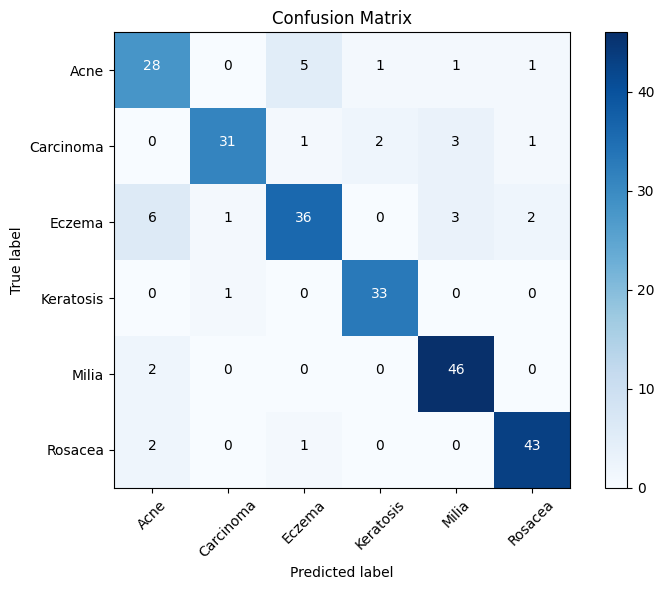

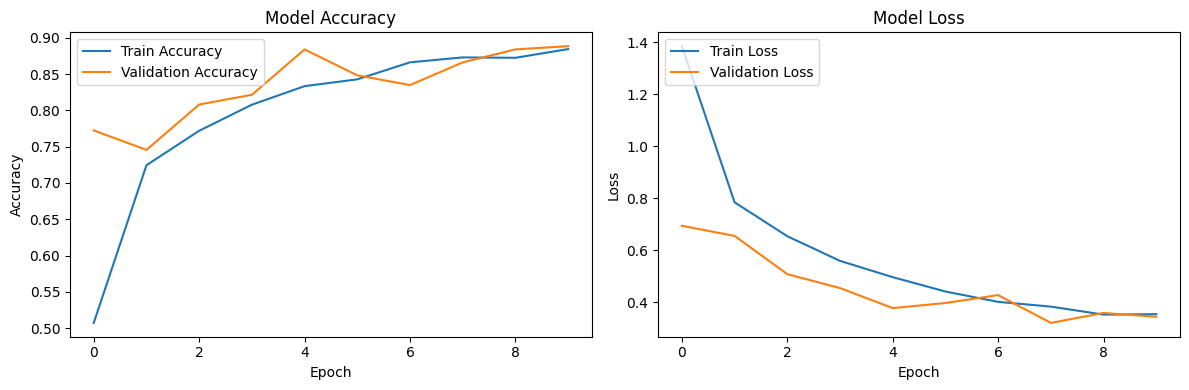

In [ ]:
# Generate predictions and create classification report
y_true, y_pred = [], []
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.class_names))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Function to Plot Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), ha="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=dataset.class_names, title='Confusion Matrix')
plt.show()

# Plot accuracy and loss curves
def plot_training_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot training curves
plot_training_curves(history_dict)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


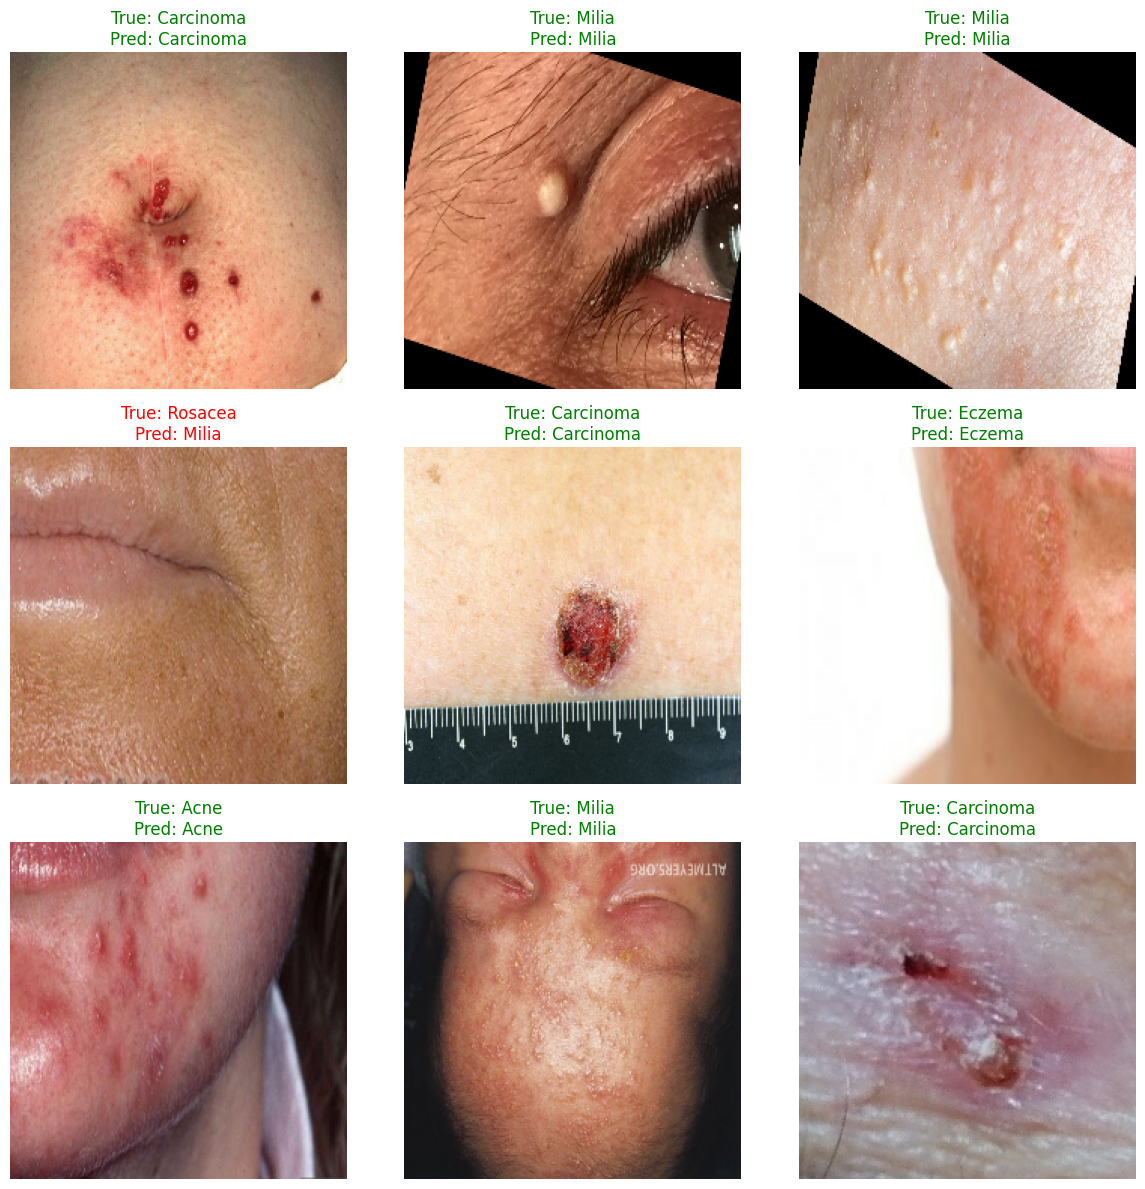

In [ ]:
import matplotlib.pyplot as plt

class_names = [
    'Acne',
    'Carcinoma',
    'Eczema',
    'Keratosis',
    'Milia',
    'Rosacea'
]

def plot_random_images(test_dataset, model, class_names, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for image_batch, label_batch in test_dataset.take(1):
        predictions = model.predict(image_batch)
        predicted_labels = np.argmax(predictions, axis=1)
        indices = np.random.choice(len(image_batch), num_images, replace=False)

        for idx, ax in enumerate(axes):
            img = image_batch[indices[idx]].numpy().astype(np.uint8)
            true_label = label_batch[indices[idx]].numpy()
            pred_label = predicted_labels[indices[idx]]

            ax.imshow(img)
            ax.axis('off')

            true_label_name = class_names[true_label]
            pred_label_name = class_names[pred_label]
            title_color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", color=title_color, fontsize=12)

    plt.tight_layout()
    plt.show()

plot_random_images(test_dataset, model, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


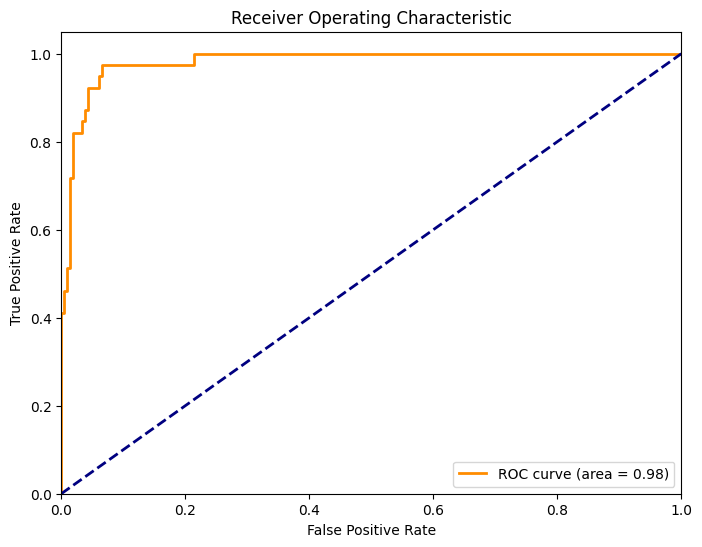

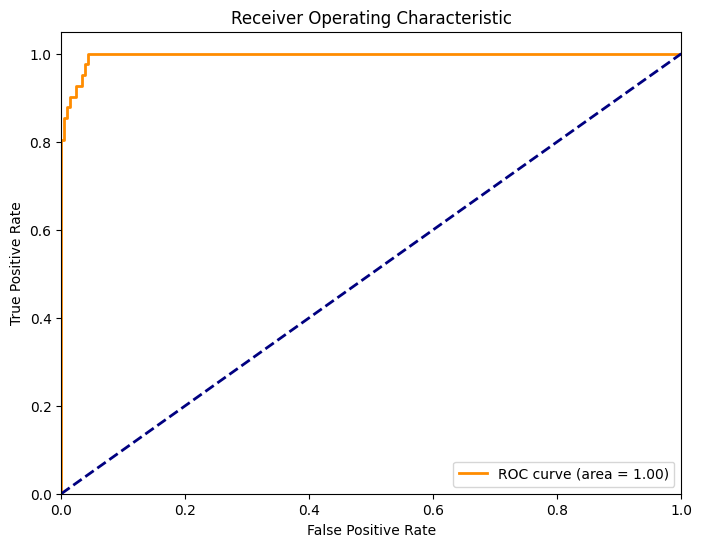

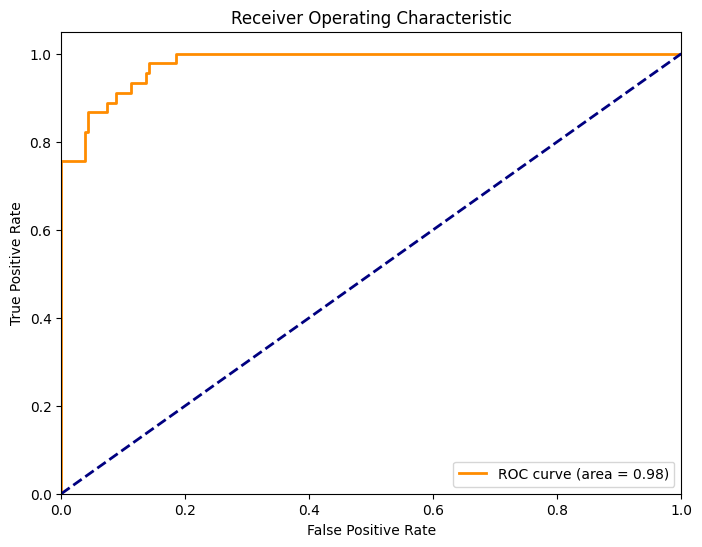

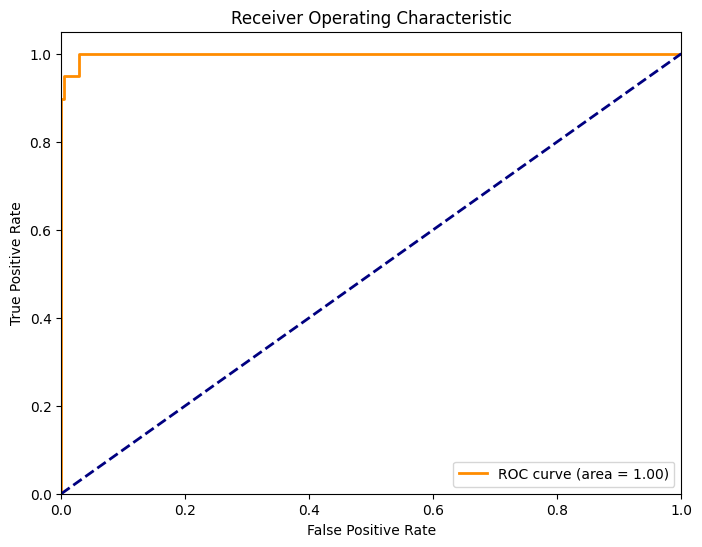

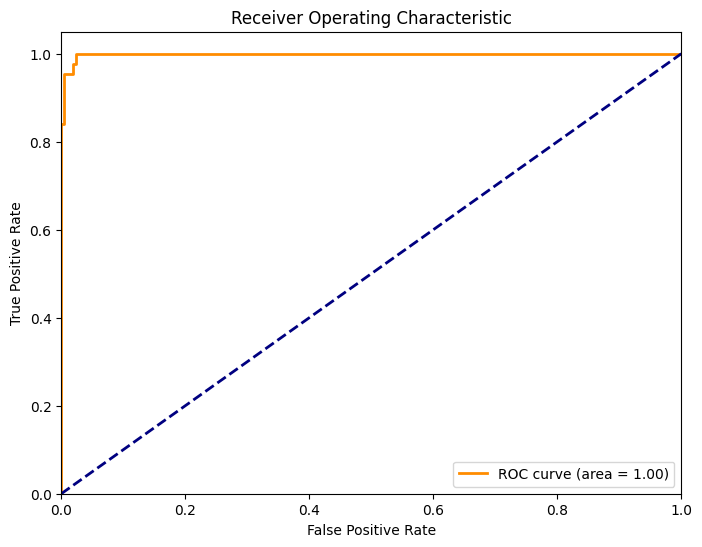

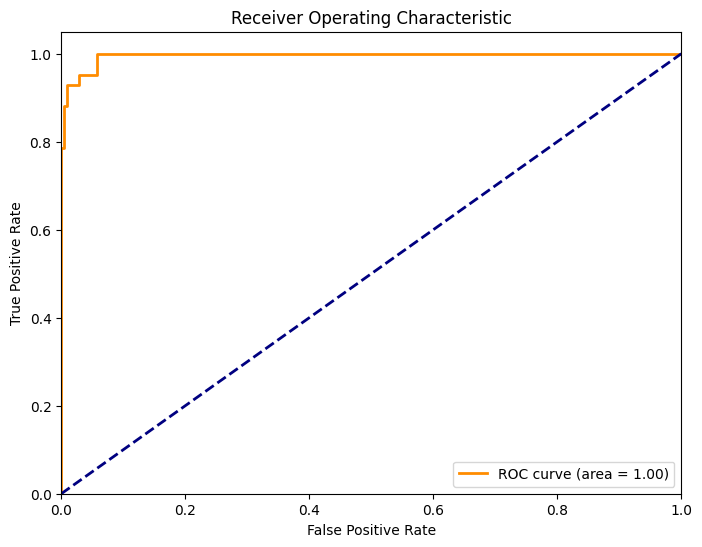

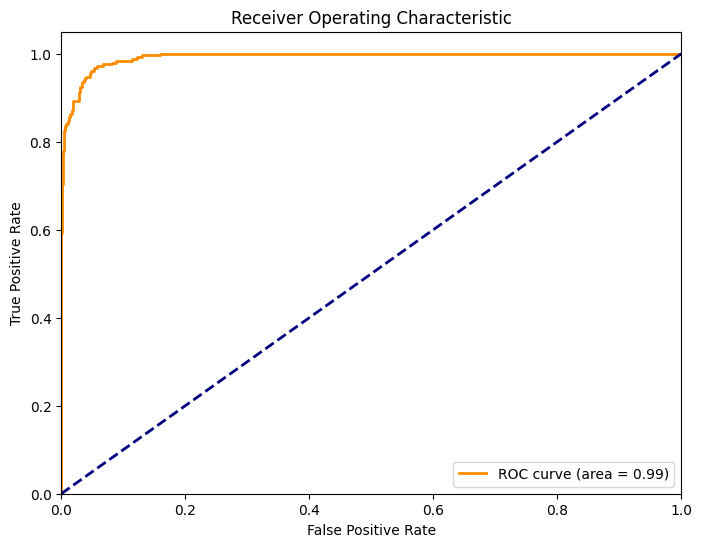

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to plot ROC curve for each class
def plot_roc_curve(fpr, tpr, auc, class_names):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Convert labels to one-hot encoding for ROC curve
y_true_one_hot = []
y_pred_probs = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true_one_hot.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_true_one_hot = label_binarize(y_true_one_hot, classes=np.arange(len(dataset.class_names)))
y_pred_probs = np.array(y_pred_probs)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(dataset.class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
for i in range(len(dataset.class_names)):
    plot_roc_curve(fpr[i], tpr[i], roc_auc[i], dataset.class_names)

# Optionally, plot a macro-average ROC curve
fpr["macro"], tpr["macro"], _ = roc_curve(y_true_one_hot.ravel(), y_pred_probs.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plot_roc_curve(fpr["macro"], tpr["macro"], roc_auc["macro"], ["Macro Average"])
